# Mean-Flow Demo

In this script, we provide a simple example of how to use mean-flow for training a one-step generative model. Where we generate hand-written digits based on the MNIST dataset.

This notebook provides a simple demonstration of mean-flow [1], a method for training efficient one-step and few-step generative models. We'll walk through the theory, the loss function, and how to use the trained model for sampling.
---

### Mean-Flow Training

The core idea is to learn the average velocity of a path that connects a point from a noise distribution $\rho_1$ (e.g., Gaussian) to a point from the target data distribution $\rho_0$.

First, we define a path, or **interpolant**, $x_t$ that smoothly transitions from a data sample $x_0 \sim \rho_0$ to a noise sample $x_1 \sim \rho_1$ as $t$ goes from 0 to 1. A simple example is the linear interpolant:

$$x_t = \alpha(t) x_0 + \beta(t) x_1,$$

where $\alpha(t) + \beta(t) = 1 \forall t \in [0, 1]$, with boundary conditions $\alpha(0) = \beta(1) = 1$ and $\alpha(1) = \beta(0) = 0$. In this case, we also define the instantaneous velocity along this path as $v(x_t, t) = \dot{x}_t$.

Thus, we define the mean velocity for two points $x_s$ and $x_t$:
$$ u(x_t, t, s) = \frac{1}{t-s}\int_{s}^{t} v(x_{\tau}, \tau) d \tau.$$

Here we assume that
$$x_t = \int_{s}^{t} v(x_{\tau}, \tau) d \tau + x_s,$$
i.e., $x_s$ and $x_t$ **correspond** to the same trajectory along the vector field generated by $v(x_{\tau}, \tau)$.

From the equation above we can see that $u(x_t, t, s)$ corresponds to the **mean** displacement
$$ u(x_t, t, s)= \frac{x_t - x_s}{t -s} = \frac{1}{t-s}\int_{s}^{t} v(x_{\tau}, \tau) d \tau.$$

Now, following [1], we rewrite this equation as
$$ (t -s ) u(x_t, t, s) =\int_{s}^{t} v(x_{\tau}, \tau) d \tau$$
and take the derivative with respect to $t$ to find that:

$$u(x_t, t, s) + (t-s) \frac{d}{dt} u(x_t, t, s) = v(x_t, t)$$

Now the task becomes training a $u_{\theta}$ to satisfy the condition above.

---
### Non-linear Fixed Point Iteration

One way to think about this is as a fixed-point iteration, namely:

$$u_{\theta^{n+1}}(x_t, t, s)  = v(x_t, t) - (t-s) \frac{d}{dt} u_{\theta^{n}}(x_t, t, s).$$

As this is difficult to perform directly, one can **reformulate it** as a minimization problem for each $\theta^{n+1}$:

$$\min_{\theta^{n+1}} \mathbb{E}_{x_0 \sim \rho_0, x_1 \sim \rho_1} \int_{[0,1]^2} \left \| u_{\theta^{n+1}}(x_t, t, s)  - \left ( v(x_t, t) - (t-s) \frac{d}{dt} u_{\theta^{n}}(x_t, t, s) \right ) \right \|^2 ds dt$$

This leads to the loss used in [1], namely:

$$\min_{\theta} \mathbb{E}_{x_0 \sim \rho_0, x_1 \sim \rho_1} \int_{[0,1]^2} \left \| u_{\theta}(x_t, t, s)  - \left ( v(x_t, t) - (t-s) \frac{d}{dt} u_{\theta^{-}}(x_t, t, s) \right ) \right \|^2 ds dt$$

where $\theta^{-}$ means that the model weights are frozen, which is instantiated by a stop gradient.

**In addition,** we can observe that when $t=s$ (i.e., on the diagonal of $[0,1]^2$) we are training a flow-matching model:

$$\min_{\theta} \mathbb{E}_{x_0 \sim \rho_0, x_1 \sim \rho_1} \int_{[0,1]} \left \| u_{\theta}(x_t, t, t)  -  v(x_t, t) \right \|^2 dt,$$

where $v(x_t, t) = \dot{x}_t = x_1 - x_0$.

Following [1], we bias the sampling of **$t$ and $s$** to sample from the diagonal fairly often (from 25% to 75% of the total samples).

---

### Sampling Using the Mean-Flow Model

For sampling, we can use either one-shot or few-shot sampling.

* **One-shot**: Here, we just use the trained model **$u_{\theta}(x_1, 1, 0)$** to generate samples by following $x_0 = x_1 - u_{\theta}(x_1, 1, 0)$.

* **Few-shot**: We assume a partition of $[0, 1]$, e.g., $0=t_0< t_1< \dots < t_{n-1} < t_n = 1$. **Here, we iteratively apply** $x_{t_{n-1}} = x_{t_{n}} - \boldsymbol{u_{\theta}}(x_{t_{n}}, t_{n}, t_{n-1})$, starting from $x_1$ to obtain a sample from $\rho_0$.

---

## References

[1] Mean Flows for One-step Generative Modeling:
*Zhengyang Geng, Mingyang Deng, Xingjian Bai, J. Zico Kolter, and Kaiming He* (2025).

As usual we start by installing the `swirl-dynamics` library.

In [ ]:
!pip install git+https://github.com/google-research/swirl-dynamics.git@main --quiet

In [ ]:
import functools
import os
from clu import metric_writers
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from orbax import checkpoint
# Imports from swirl-dynamics codebase.
from swirl_dynamics.projects.debiasing.stochastic_interpolants import backbones
from swirl_dynamics.projects.debiasing.stochastic_interpolants import interpolants
from swirl_dynamics.projects.distillation.mean_flow import models as mean_flow_models
from swirl_dynamics.projects.distillation.mean_flow import trainers as mean_flow_trainers
from swirl_dynamics.templates import callbacks
from swirl_dynamics.templates import train
import tensorflow as tf
import tensorflow_datasets as tfds

We define the dataloader. Here we leverage the data in `tfds`, and we apply the appropiate transformations.

In [ ]:
def get_mnist_dataset(split: str, batch_size: int):
  ds = tfds.load("mnist", split=split)
  ds = ds.map(
      # Here \rho_0 is the target distribution and \rho_1 is the noise.
      lambda x: {
          "x_1": tf.random.normal(shape=x["image"].shape, mean=0.0),
          "x_0": tf.cast(x["image"], tf.float32) / 255.0,
          "emb:label": x["label"],
      }
  )
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  ds = ds.as_numpy_iterator()
  return ds

We define the parameters for the neural architecture and the training hyperparameters. For simplicity we store them in a configDict and we will use them when necessary.

In [ ]:
import ml_collections

config = ml_collections.ConfigDict()

# Parameters for training.
config.num_train_steps = 100_000
config.seed = 777
config.metric_aggregation_steps = 500
config.save_interval_steps = 6_000
config.max_checkpoints_to_keep = 10
config.max_norm = 1.0
config.eval_every_steps = 10_000
config.num_batches_per_eval = 1

# Optimizer parameters.
config.initial_lr = 1e-7
config.peak_lr = 1e-4
config.warmup_steps = 10_000
config.end_lr = 1e-7
config.beta1 = 0.9

# Dataloader parameters
config.batch_size = 128  # one sample per chip.
config.batch_size_eval = 16
# This controls the ratio of samples in the diagonal s=t.
config.diagonal_sampling_rate = 0.5

# Model params
config.time_rescale = 1.0
config.out_channels = 1
config.num_channels = (64, 128)
config.downsample_ratio = (
    2,
    2,
)
config.use_global_skip = False
config.frequency_scaling = "exponential"
config.min_freq = 1.0
config.max_freq = 512.0
config.time_embedding_merge = "concat"
config.frequency_shift = 0.0


config.num_blocks = 4
config.dropout_rate = 0.5
config.noise_embed_dim = 64
config.padding = "SAME"
config.use_attention = True
config.use_position_encoding = True
config.num_heads = 64
config.ema_decay = 0.99
config.input_shapes = ((1, 28, 28, 1), (1, 28, 28, 1))
config.min_time = 0.0
config.max_time = 1.0
config.normalize_qk = True


config.input_shapes = ((1, 28, 28, 1), (1, 28, 28, 1))

## Defining the mean flow model.

Here we instantiate the model as a neural architecture, then we wrap it around using a `model` object, then we define the hyperparameters for training, the trained and we simply train the model. Given that this is already explained for the rectified flow [here](https://github.com/google-research/swirl-dynamics/blob/main/swirl_dynamics/projects/debiasing/rectified_flow/colab/demo_reflow.ipynb) and the stochastic interpolants [here](https://github.com/google-research/swirl-dynamics/tree/main/swirl_dynamics/projects/debiasing/stochastic_interpolants/colabs) we only provide a quick overview of the training pipeline.


We define, instantiate, and wrap the mean flow model. Here we define a custom sampler.

In [ ]:
mean_flow_nn_model = mean_flow_models.RescaledMeanFlowUNet(
    time_rescale=config.time_rescale,
    out_channels=config.out_channels,
    num_channels=config.num_channels,
    downsample_ratio=config.downsample_ratio,
    num_blocks=config.num_blocks,
    noise_embed_dim=config.noise_embed_dim,
    padding=config.padding,
    use_attention=config.use_attention,
    use_position_encoding=config.use_position_encoding,
    num_heads=config.num_heads,
    use_global_skip=config.use_global_skip,
    dropout_rate=config.dropout_rate,
    frequency_scaling=config.frequency_scaling,
    frequency_shift=config.frequency_shift,
    time_embedding_merge=config.time_embedding_merge,
    min_freq=config.min_freq,
    max_freq=config.max_freq,
    # We add a conditining for the class of the digit.
    cond_embed_fn=backbones.MergeCategoricalEmbCond,
    cond_embed_kwargs={
        "cond_key": "emb:label",
        "num_classes": 10,
        "features_embedding": config.noise_embed_dim,
    },
)

# We use a time sampler using a logit-normal distribution with mean -.4.
time_sampler_logit = functools.partial(
    mean_flow_models.time_sampler_mean_flow,
    time_sampling=functools.partial(
        mean_flow_models.logit_normal_dist,
        mean=-0.4,
        std=1.0,
        dtype=jnp.float32,
    ),
)

mean_flow_model = mean_flow_models.ConditionalMeanFlowModel(
    input_shape=config.input_shapes[0][1:],
    cond_shape={"emb:label": ()},  # This is a scalar.
    mean_flow_model=mean_flow_nn_model,  # model to learn
    flow_model=None,  # No teacher model, so we learn the model directly.
    params_flow=None,  # No teacher model, so we learn the model directly.
    interpolant=interpolants.RectifiedFlow(),  # Stochastic interpolant.
    diagonal_sampling_rate=config.get("diagonal_sampling_rate", 0.75),
    time_sampling=time_sampler_logit,
    min_train_time=config.min_time,
    max_train_time=config.max_time,
)

Define the optimizer (with its corresponding schedule), and the trainer (including the checkpointer). We also define the workding directory to save the checkpoints.

In [ ]:
schedule = optax.warmup_cosine_decay_schedule(
    init_value=config.initial_lr,
    peak_value=config.peak_lr,
    warmup_steps=config.warmup_steps,
    decay_steps=config.num_train_steps,
    end_value=config.end_lr,
)

optimizer = optax.chain(
    optax.clip(config.max_norm),
    optax.adam(
        learning_rate=schedule,
        b1=config.beta1,
    ),
)
trainer = mean_flow_trainers.DistributedMeanFlowTrainer(
    model=mean_flow_model,
    rng=jax.random.PRNGKey(config.seed),
    optimizer=optimizer,
    ema_decay=config.ema_decay,
)

# Setting up checkpointing.
ckpt_options = checkpoint.CheckpointManagerOptions(
    save_interval_steps=config.save_interval_steps,
    max_to_keep=config.max_checkpoints_to_keep,
)

workdir = os.path.join(os.getcwd(), "mean_flow")

### Training the mean-flow model.

Define the dataloders and train the mean flow model. Training if usually requires a larger amount of iterations compared to a rectified model. This step should take around 1.5 hours in a `TPU v6e`.

In [ ]:
# Instantiate the dataloaders.
train_dataloader = get_mnist_dataset(
    split="train", batch_size=config.batch_size
)
eval_dataloader = get_mnist_dataset(split="test", batch_size=config.batch_size)

In [ ]:
# We avoid using the evaluation so the training runs a bit faster.
train.run(
    train_dataloader=train_dataloader,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=config.num_train_steps,
    metric_aggregation_steps=config.metric_aggregation_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    callbacks=(
        # This callback shows a progress bar.
        callbacks.TqdmProgressBar(
            total_train_steps=config.num_train_steps,
            train_monitors=("train_loss",),
        ),
        # This callback saves model checkpoint periodically.
        callbacks.TrainStateCheckpoint(
            base_dir=workdir,
            options=ckpt_options,
        ),
    ),
)

## Testing the trained model

Here we consider the model above and we sample from it.

### Sampling from the trained model

In [ ]:
# Loads the weights.
trained_flow_state = mean_flow_trainers.TrainState.restore_from_orbax_ckpt(
    f'{workdir}/checkpoints', step=None
)
inference_fn = mean_flow_model.inference_fn(
    trained_flow_state.model_variables, mean_flow_model.mean_flow_model
)

# Extracts a batch, and gets the conditioning.
batch = next(iter(eval_dataloader))
cond = {'emb:label': batch['emb:label']}

Array = jax.Array


@jax.jit
def generate_one_shot_samples(x_1: Array, cond: dict[str, Array]):
  r"""Generates samples from the trained mean flow model.

  Args:
    x_1: Noise input
    cond: Conditining vector

  Returns:
    One-shot generates sample, following:
      $$x_0 = x_1 - u(x_1, 1, 0; c),$$
    where $u$ is the mean flow, and c is the conditioning.
  """
  num_samples = x_1.shape[0]
  t, s = jnp.ones((num_samples,)), jnp.zeros(
      num_samples,
  )
  x_0 = x_1 - inference_fn(x_1, t, s, cond)
  return x_0


samples_mean_flow = generate_one_shot_samples(
    batch['x_1'], cond
).block_until_ready()

We time the execution time of the generation.

In [ ]:
%%timeit
samples_mean_flow = generate_one_shot_samples(
    batch["x_1"], cond
).block_until_ready()

### Plotting the generated samples.

Here we plot the samples. Consider that the network is quite small and it hasn't been exhaustively trained, so the quality of the samples can be further improved.

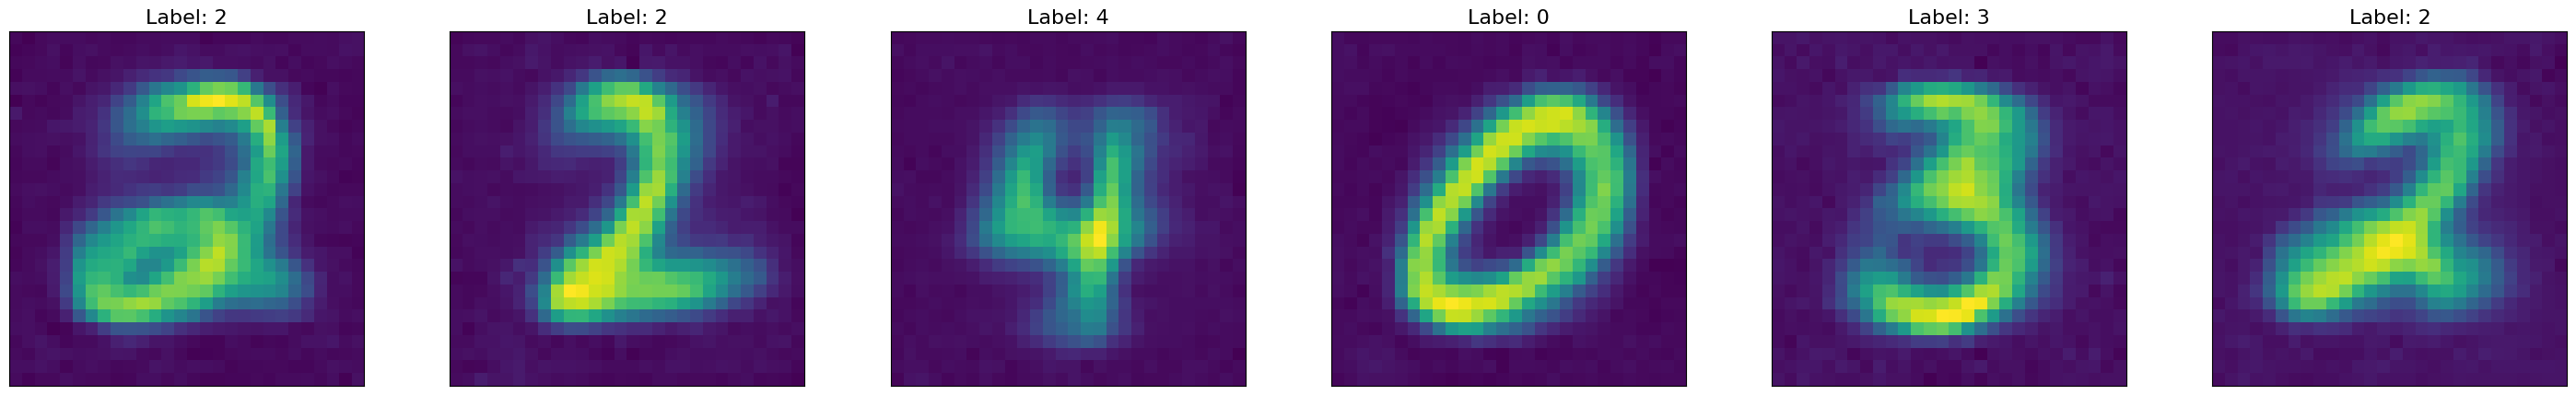

In [ ]:
num_cols = 6
plt.figure(figsize=(num_cols * 6, 5))
for i in range(1, num_cols + 1):
  plt.subplot(1, num_cols, i)
  plt.imshow(samples_mean_flow[i - 1, :, :, 0])
  plt.yticks(ticks=[], labels=[])
  plt.xticks(ticks=[], labels=[])
  plt.title(f"Label: {cond['emb:label'][i-1]}", fontsize=16)
plt.show()

### Few-Shots Generation

We define the function for the few-shots generation, and we perform a 2-shot generation.

In [ ]:
@jax.jit
def generate_few_shots_samples(
    x_1: Array, cond: dict[str, Array], num_steps: int
) -> Array:
  def body_for_loop(i, x, cond, delta_t):
    return x - inference_fn(
        x,
        delta_t * (num_steps - i) * jnp.ones((x.shape[0],)),
        delta_t * (num_steps - (i + 1)) * jnp.ones((x.shape[0],)),
        cond,
    )

  delta_t = 1.0 / num_steps
  body_for_loop = functools.partial(body_for_loop, delta_t=delta_t, cond=cond)
  samples = jax.lax.fori_loop(0, num_steps, body_for_loop, x_1)

  return samples


samples_mean_flow_2_shots = generate_few_shots_samples(
    batch['x_1'], cond, 2
).block_until_ready()

We also time the generation (unsurprinsingly it should be roughly twice as slow).

In [ ]:
%%timeit
samples_mean_flow_2_shots = generate_few_shots_samples(
    batch["x_1"], cond, 2
).block_until_ready()

We plot the generated numbers.

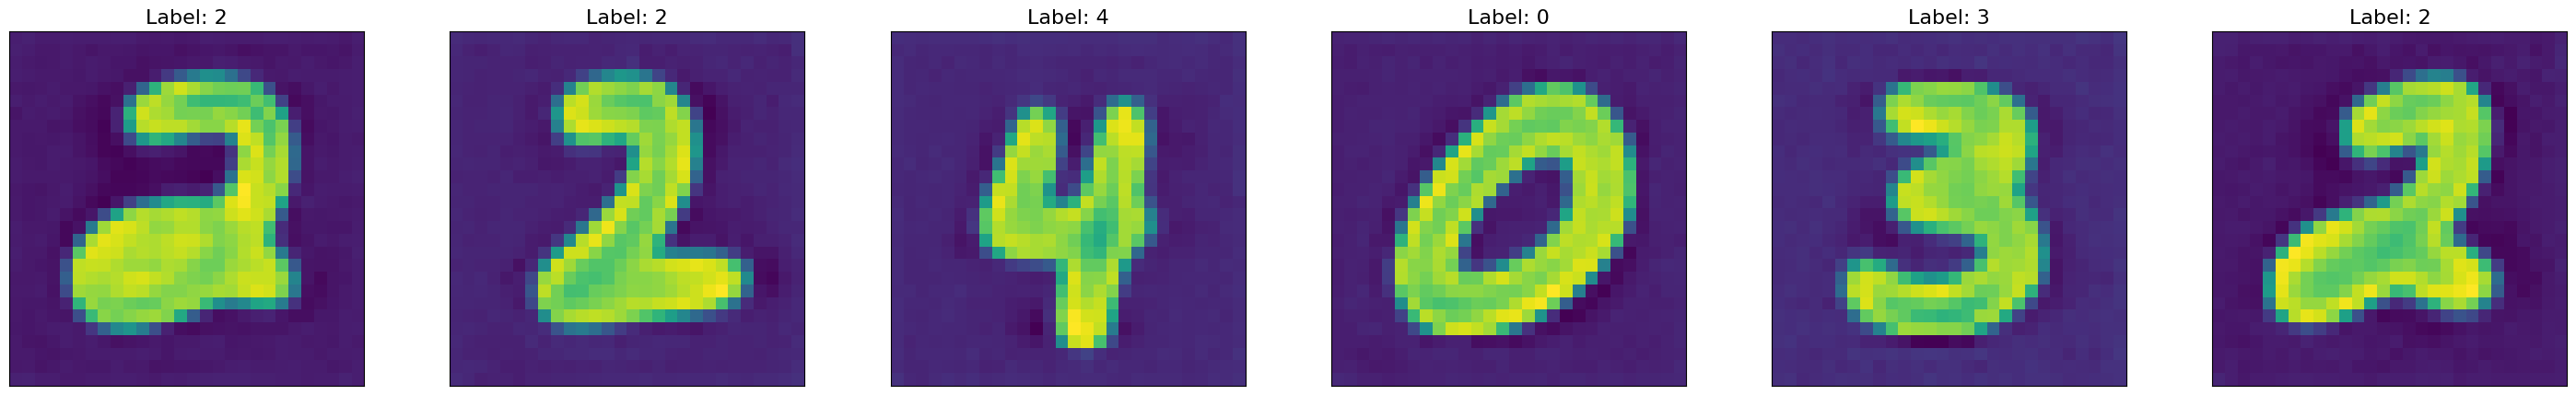

In [ ]:
num_cols = 6
plt.figure(figsize=(num_cols * 6, 5))
for i in range(1, num_cols + 1):
  plt.subplot(1, num_cols, i)
  plt.imshow(samples_mean_flow_2_shots[i - 1, :, :, 0])
  plt.yticks(ticks=[], labels=[])
  plt.xticks(ticks=[], labels=[])
  plt.title(f"Label: {cond['emb:label'][i-1]}", fontsize=16)
plt.show()